In [1]:
!pip install imbalanced-learn

You should consider upgrading via the '/home/ubuntu/pyenv/bin/python -m pip install --upgrade pip' command.


In [68]:
import sys
from pprint import pprint
from pymongo import MongoClient 
import torch
import json
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import imblearn
import numpy as np

## Database Handling

In [28]:
df = pd.read_pickle("repeated-malicious-ip-classifier/pickles/processed_data_94800.pkl")

In [30]:
df.head()

,ip,data.message,data.sensor_geo.$binary.base64,data.sensor_segment.$binary.base64,data.ip_country,data.bf,data.sensor,data.src_ip,data.sen_dist,data.src_uptime_sec,...,session.params,command.input,session.file_download,session.file_download.failed,command.failed,session.file_upload,client.var,command.success,data.session,client.size
0,206.189.48.208,1 Closing TTY Log: var/lib/cowrie/tty/287...,REU=,Rkk=,DE,0,sensingforever1,206.189.48.208,Linux-5.4.0-1045-aws-x86_64-with-glibc2.29,1.0,...,8,10,0,0,0,0,0,0,6bb9d8312f0f,NaN
1,36.92.74.150,2 SSH client hassh fingerprint: 98ddc5604...,U0c=,R08=,ID,0,ip-172-31-16-246,36.92.74.150,Linux-5.4.0-1045-aws-x86_64-with-glibc2.29,0.0,...,0,0,0,0,0,0,0,0,758050351b74,NaN
2,79.106.48.178,3 login attempt [root/19810927] succeeded\n...,REU=,Rkk=,AL,0,sensingforever1,79.106.48.178,Linux-5.4.0-1045-aws-x86_64-with-glibc2.29,1.0,...,0,0,0,0,0,0,0,0,69047a31fde2,NaN
3,154.221.20.149,4 Connection lost after ...,VVM=,VEU=,HK,0,ip-172-31-10-243,154.221.20.149,Linux-5.4.0-1038-aws-x86_64-with-glibc2.29,1.0,...,0,0,0,0,0,0,0,0,3e6b78310e36,NaN
4,111.119.183.31,5 SSH client hassh fingerprint: 98ddc5604...,U0c=,Rkk=,PK,0,ip-172-31-17-24,111.119.183.31,Linux-5.4.0-1045-aws-x86_64-with-glibc2.29,0.0,...,0,0,0,0,0,0,0,0,5ea2f4c8f6e0,NaN


## Preprocessing

In [29]:
df["data.bf"][df["data.bf"] == True] = 1
df["data.bf"][df["data.bf"] == False] = 0
df["data.bf"][df["data.bf"].isna()] = 0

/tmp/ipykernel_1210/529168302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["data.bf"][df["data.bf"] == True] = 1
/tmp/ipykernel_1210/529168302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["data.bf"][df["data.bf"] == False] = 0
/tmp/ipykernel_1210/529168302.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["data.bf"][df["data.bf"].isna()] = 0


In [31]:
def add_label_column(df) -> None:
    """ Adding the label - 0 if ip doesn't return in the data, else 1. """

    df["label"] = 0
    unique_ips = df["ip"].unique()

    # label creation
    for i, ip in enumerate(unique_ips):
        # logging
        if i % 100 == 0:
            print(f'{i}. IP {ip}')

        sessions = df[df["ip"] == ip]["data.session"].unique()  # all sessions with the same IP
        if len(sessions) != 1:  # IP is repeated in different sessions
            df.loc[df.ip == ip, "label"] = 1

In [32]:
add_label_column(df)

0. IP 206.189.48.208
100. IP 222.186.180.130
200. IP 115.159.63.123
300. IP 150.158.186.247
400. IP 66.23.228.254
500. IP 201.156.224.108
600. IP 198.199.97.218
700. IP 220.164.118.16
800. IP 119.91.108.17
900. IP 159.75.138.194
1000. IP 95.169.5.166
1100. IP 106.54.86.61
1200. IP 185.180.143.16
1300. IP 73.76.104.145
1400. IP 93.42.100.147
1500. IP 187.188.107.115
1600. IP 14.174.138.193
1700. IP 106.13.19.75
1800. IP 189.209.98.156
1900. IP 47.44.215.186
2000. IP 169.239.73.106
2100. IP 1.15.81.243
2200. IP 107.189.10.42
2300. IP 185.118.50.218
2400. IP 121.166.68.59
2500. IP 178.176.250.18
2600. IP 192.241.220.29
2700. IP 101.69.200.162
2800. IP 160.251.8.225
2900. IP 206.189.64.176
3000. IP 221.213.129.46
3100. IP 200.106.192.2
3200. IP 85.209.224.93
3300. IP 51.89.103.161
3400. IP 49.234.93.52
3500. IP 181.166.149.248
3600. IP 200.92.226.50
3700. IP 106.13.23.86
3800. IP 188.127.178.55
3900. IP 178.128.221.85
4000. IP 121.4.189.2
4100. IP 68.183.134.255
4200. IP 51.158.123.160
430

In [33]:
del df["data.session"]

In [34]:
if df.iloc[-1].isnull().values.any():
    # remove the last row if it contains a nan
    df = df.iloc[:-1]

## Exploratory Data Analysis

In [46]:
df.describe(include='all')

,ip,data.message,data.sensor_geo.$binary.base64,data.sensor_segment.$binary.base64,data.ip_country,data.bf,data.sensor,data.src_ip,data.sen_dist,data.src_uptime_sec,...,session.params,command.input,session.file_download,session.file_download.failed,command.failed,session.file_upload,client.var,command.success,client.size,label
count,94799,94799,94799,94799,94679,94799.0,94799,94799,94799,94799.000000,...,94799.0,94799.0,94799.0,94799.0,94799.0,94799.0,94799.0,94799.0,5.0,94799.000000
unique,5810,94018,14,10,134,1.0,78,5810,3,NaN,...,19.0,25.0,5.0,3.0,9.0,2.0,2.0,4.0,NaN,NaN
top,79.106.48.178,215 Connection lost after 0 seconds,REU=,Rkk=,CN,0.0,sensingforever1,79.106.48.178,Linux-5.4.0-1045-aws-x86_64-with-glibc2.29,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
freq,7162,5,59042,63142,23776,94799.0,58975,7162,67848,NaN,...,74705.0,74716.0,89002.0,93557.0,94453.0,94778.0,94797.0,94788.0,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.869007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.987257
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.337394,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.112163
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000


In [47]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/40 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

data.bf


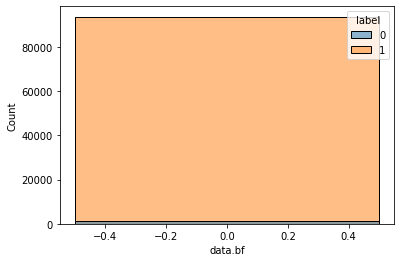

data.sensor_geo.$binary.base64


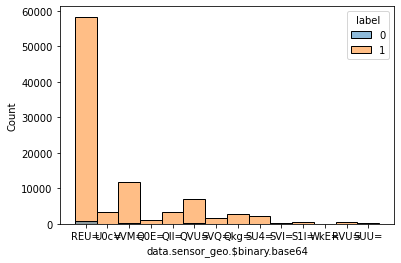

data.sensor_segment.$binary.base64


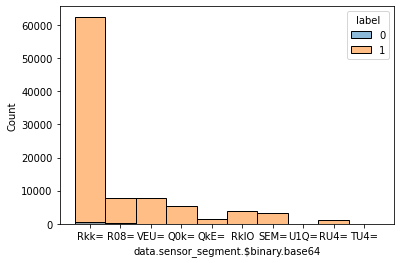

log.closed


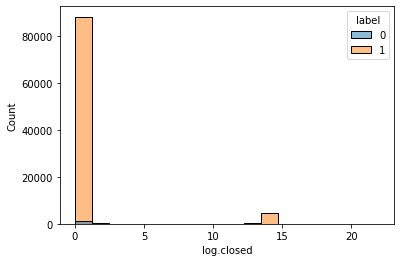

client.kex


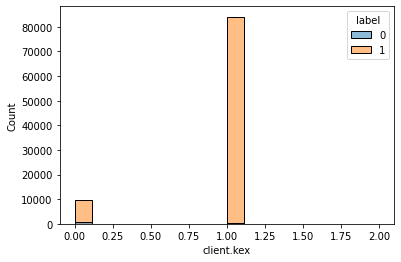

login.success


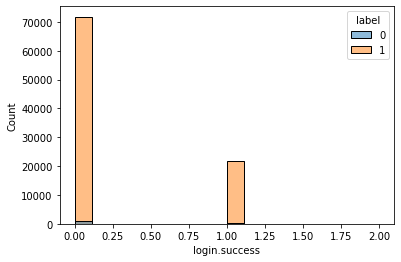

session.closed


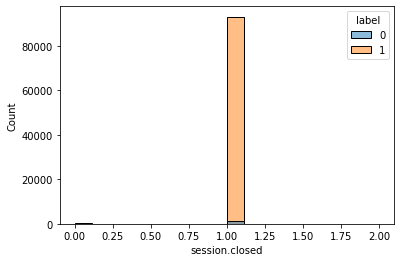

client.version


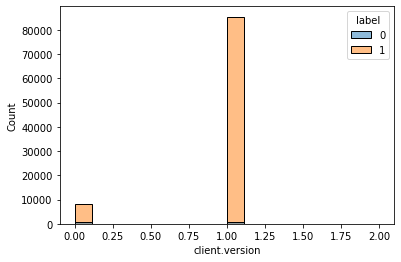

session.params


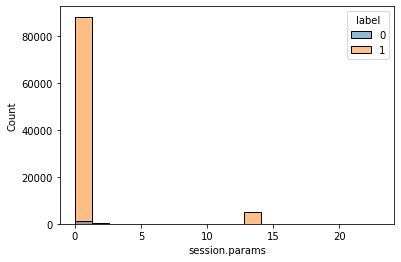

command.input


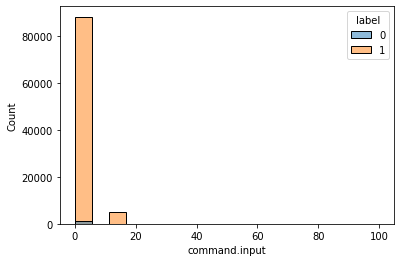

session.file_download


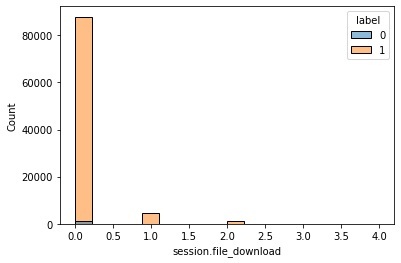

session.file_download.failed


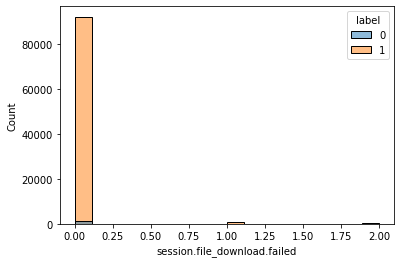

command.failed


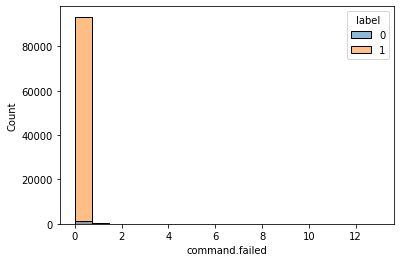

session.file_upload


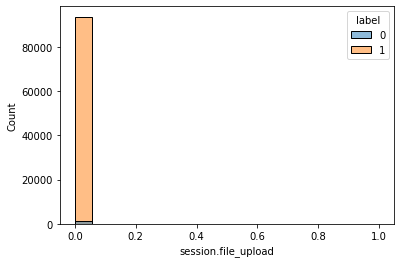

client.var


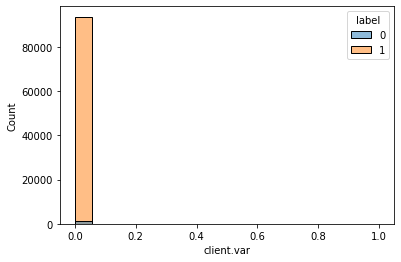

command.success


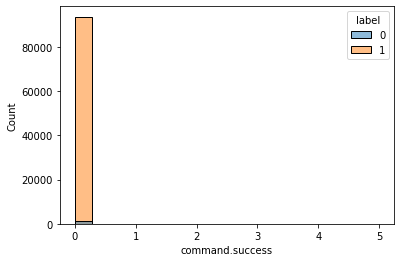

client.size


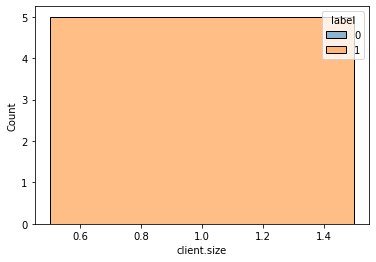

data.src_uptime_sec


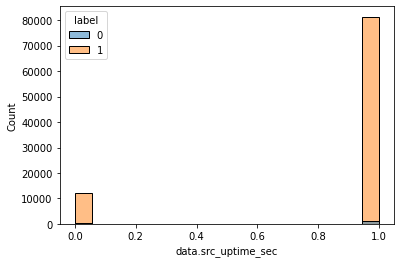

In [35]:
columns = ['data.bf', 'data.sensor_geo.$binary.base64',
           'data.sensor_segment.$binary.base64', 'log.closed',
       'client.kex', 'login.success', 'session.closed', 'client.version',
       'session.params', 'command.input', 'session.file_download',
       'session.file_download.failed', 'command.failed', 'session.file_upload',
       'client.var', 'command.success', 'client.size', 'data.src_uptime_sec']
for col in columns:
    print(col)
    sns.histplot(data=df, x=col, hue="label")
    plt.show()

## Model Selection

In [36]:
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [48]:
def factorize_df(df, categorical_cols) -> pd.DataFrame:
    """ Transforms non-numeric values into dummy values """

    new_df = pd.DataFrame(columns=df.columns)
    for col in categorical_cols:
        new_df[col], _ = df[col].factorize()
    not_categorical_cols = [col for col in df.columns if col not in categorical_cols]
    for col in not_categorical_cols:
        new_df[col] = df[col]
    return new_df

In [49]:
categorical_cols = ["ip", "data.sensor_geo.$binary.base64", "data.sensor_segment.$binary.base64",
                    "data.ip_country", "data.message", "data.sensor", "data.src_ip", "data.sen_dist",
                    "data.src_language", "data.src_os_name"]
df = factorize_df(df, categorical_cols)

In [56]:
%cd repeated-malicious-ip-classifier
from train import get_train_test_data
%cd ..

/home/ubuntu/repeated-malicious-ip-classifier
/home/ubuntu


In [51]:
X_train, X_test, y_train, y_test = get_train_test_data(df, True)

2021-09-11 10:33:42.886624 Train: 1    93591
0     1208
Name: label, dtype: int64
2021-09-11 10:33:42.992330 Train:  ========== X_train size: 68759, y_train size: 68759 ========== X_test size: 26040, y_test size: 26040 ==========


In [58]:
models = [
    SVC(random_state=1),
    MLPClassifier(random_state=1),
    RandomForestClassifier(random_state=1),
    BalancedBaggingClassifier(),
    RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', random_state=1),
    BalancedRandomForestClassifier()
]

model_names = ["SVC", "MLP", "Random\nForest", "Balanced\nBagging", "Random\nForest\nv2", "Balanced\nRandom\nForest"]
precisions = []
recalls = []
fprs = []


for model in models:
    print(model)
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test).round()
    precision = precision_score(y_test, test_preds)
    recall = recall_score(y_test, test_preds)
    precisions.append(precision)
    recalls.append(recall)

    print("precision_score on test:", precision)
    print("recall_score on test:", recall)

    fps = ((y_test != test_preds) & (test_preds == 1)).sum()
    total_negatives = (y_test == 0).sum()
    fpr = fps/total_negatives
    print("num fps:", fps, "fpr:", fpr, "\n")
    fprs.append(fpr)

SVC(random_state=1)
precision_score on test: 0.984715821812596
recall_score on test: 1.0
num fps: 398 fpr: 1.0 

MLPClassifier(random_state=1)
precision_score on test: 0.9848286987248426
recall_score on test: 0.9999610014819437
num fps: 395 fpr: 0.992462311557789 

RandomForestClassifier(random_state=1)
precision_score on test: 0.9888113523839227
recall_score on test: 0.9891584119803447
num fps: 287 fpr: 0.7211055276381909 

BalancedBaggingClassifier()
precision_score on test: 0.9967988434531185
recall_score on test: 0.7529053895951954
num fps: 62 fpr: 0.15577889447236182 

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=10,
                       random_state=1)
precision_score on test: 0.9885848318999219
recall_score on test: 0.9861945246080649
num fps: 292 fpr: 0.7336683417085427 

BalancedRandomForestClassifier()
precision_score on test: 0.9977462974887314
recall_score on test: 0.7251384447390999
num fps: 42 fpr: 0.10552763819095477 



### Precisions Plot

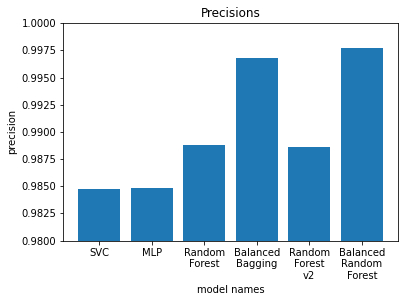

In [59]:
plt.bar(model_names, precisions)
plt.ylim(0.98, 1)
plt.title('Precisions')
plt.xlabel('model names')
plt.ylabel('precision')
plt.show()

### Recalls Plot

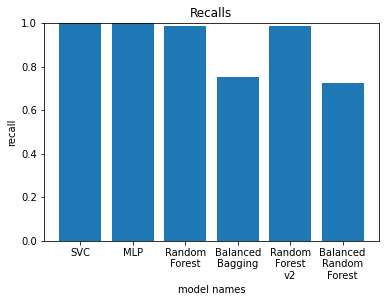

In [60]:
plt.bar(model_names, recalls)
plt.ylim(0, 1)
plt.title('Recalls')
plt.xlabel('model names')
plt.ylabel('recall')
plt.show()

### FPRs Plot

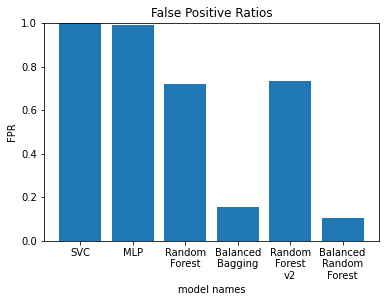

In [61]:
plt.bar(model_names, fprs)
plt.ylim(0, 1)
plt.title('False Positive Ratios')
plt.xlabel('model names')
plt.ylabel('FPR')
plt.show()

### Find best random state

In [64]:
rf_precisions = []
rf_recalls = []
rf_fprs = []

for random_state in range(50):
    model = BalancedRandomForestClassifier(random_state=random_state)
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test).round()
    precision = precision_score(y_test, test_preds)
    recall = recall_score(y_test, test_preds)
    rf_precisions.append(precision)
    rf_recalls.append(recall)
    fps = ((y_test != test_preds) & (test_preds == 1)).sum()
    total_negatives = (y_test == 0).sum()
    fpr = fps/total_negatives
    rf_fprs.append(fpr)

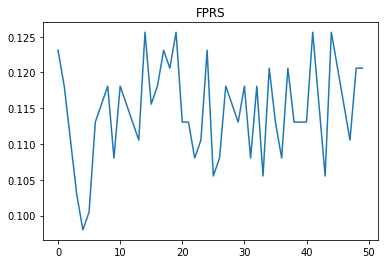

In [78]:
plt.plot(range(50), rf_fprs)
plt.title('FPRS')
plt.show()

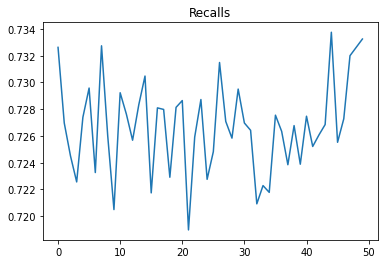

In [80]:
plt.plot(range(50), rf_recalls)
plt.title('Recalls')
plt.show()

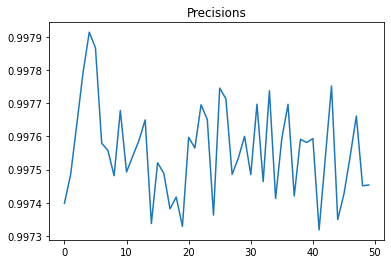

In [81]:
plt.plot(range(50), rf_precisions)
plt.title('Precisions')
plt.show()

In [82]:
np.argmin(rf_fprs)

4

In [88]:
print(str((rf_fprs[4] * 100).round(2)) + " %")

9.8 %
